# Prise en main d'Atom

In [1]:
from atom import *
import numpy as np
import random
import scipy.stats as sst
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

## Tutoriel

Pour créer un marché, il suffit de faire `Market(assets)`, où `assets` est la liste des assets du marché. De base, il existe deux types d'agents :
* Des dumb agents, qui n'envoient aucun ordres hormis ceux qu'on leur demande d'envoyer
* Des ZIT, qui envoient, à chaque fois qu'ils ont la parole, un ordre aléatoire, dont le prix est tiré uniformément entre 1000 et 9999 et la quantité entre 1 et 9.

Pour créer ces agents, le marché doit leur être passé en paramètre. Ensuite, la méthode `add_trader` du marché permet de rajouter notre agent au marché.

### Dumb Agents

Un dumb agent n'est qu'un intermédiaire entre nous et le marché pour qu'on puisse envoyer l'ordre que l'on souhaite. Pour ce faire, on utilise la méthode `send_order` de l'agent, qui prend en paramètres un ordre et le marché.

Le premier type d'ordre est les limit orders, que l'on créé avec la commande `LimitOrder(asset, source, direction, price, qty)`.

In [2]:
m = Market(['Apple', 'Google']) # Créé un marché dont les assets sont 'Apple' et 'Google'
t = DumbAgent(m) # Créé un dumb agent
m.add_trader(t) # Rajoute le dumb agent au marché

t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)
# Le dumb agent a envoyé au marché un ordre de vente de 10 actions Apple au prix 5000
t.send_order(LimitOrder('Apple', t, 'BID', 6000, 5), m)
# Le dumb agent a envoyé au marché un ordre d'achat de 5 actions Apple au prix 6000

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;Dumby 1;0;Apple:0,Google:0
AgentWealth;Dumby 1;0;197
LimitOrder;Apple;Dumby 1;ASK;5000;10
LimitOrder;Apple;Dumby 1;BID;6000;5
Price;Apple;Dumby 1;Dumby 1;5000;5;518
Agent;Dumby 1;0;Apple;0;536
AgentWealth;Dumby 1;0;552


### Trace

On remarque qu'en sortie, on obtient la trace de toutes les opérations effectuées. Les premières lignes (commençant par '#') de cette trace précisent la syntaxe utilisée.
* Les lignes LimitOrder et CancelMyOrders sont affichées quand un ordre (LimitOrder ou CancelMyOrders) a été envoyé
* Les lignes Tick correspondent à une fin de tick
* Les lignes Price sont affichées quand un prix est fixé (long fixing)
* Les lignes NewAgent sont affichées quand un agent est rajouté au marché
* Les lignes Agent sont affichées quand un agent a son cash ou sa quantité d'actions qui sont modifées
* Les lignes AgentWealth correspondent au wealth des agents

On peut afficer cette trace à différents endroit, à l'aide du paramètre `out` quand on créé le marché :
* Si rien n'est précisé, la trace est affichée dans la console
* Si `out = None`, rien n'est affiché
* Si `out = FileObject`, la trace est affichée dans un fichier. Si on utilise cette méthode, il est impératif de penser à fermer le fichier après qu'on ait fini d'écrire dedans.

In [3]:
file = open('trace.dat', 'w') # On ouvre le fichier trace.dat en écriture

m = Market(['Apple'], out=file) # On donne ce fichier au marché
t = DumbAgent(m)
m.add_trader(t)
t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)

file.close() # On n'oublie pas de fermer le fichier.

Le marché a également un paramètre `print_orderbooks`, qui vaut `False` lorsque rien n'est précisé. Quand ce paramètre vaut `True`, les orderbooks sont affichés à chaque fois qu'ils sont modifiés.

En outre, on dispose d'une méthode `print_state()` sur le marché, qui affiche le nombre d'ordres reçus, le nombre de prix fixés et le nombre d'ordres ASK et BID en attente.

In [4]:
file = open('trace.dat', 'w') # On ouvre le fichier trace.dat en écriture

m = Market(['Apple'], out=file)
t = DumbAgent(m)
m.add_trader(t)
t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)
t.send_order(LimitOrder('Apple', t, 'BID', 6000, 5), m)
m.print_state()

file.close()

Regarder le fichier trace.dat. Il contient la trace, dans laquelle sont aussi affichés les orderbooks dès qu'ils sont modifiés (après avoir reçu un prix, ou après avoir fixé un prix).

### ZITs

Les ZITs peuvent être créés de la même façon que les dumb agents, en utilisant la commande `ZITTrader(m)`. Une fois les ZITs créés et ajoutés au marché, on peut utiliser la méthode du marché `run_once()`, qui donne la parole à chaque agent sur chaque asset.

In [5]:
m = Market(['Apple'])
m.add_trader(ZITTrader(m))
m.add_trader(ZITTrader(m))
m.run_once()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;ZIT 4;0;Apple:0
AgentWealth;ZIT 4;0;107
NewAgent;ZIT 5;0;Apple:0
AgentWealth;ZIT 5;0;169
LimitOrder;Apple;ZIT 4;BID;7305;8
LimitOrder;Apple;ZIT 5;ASK;4550;1
Price;Apple;ZIT 4;ZIT 5;7305;1;262
Agent;ZIT 5;7305;Apple;-1;272
Agent;ZIT 4;-7305;Apple;1;281
AgentWealth;ZIT 4;0;291
AgentWealth;ZIT 5;0;299
Tick;1


On peut aussi utiliser la méthode du maché `generate(nb_ZIT, nb_turn)`, qui créé nb_ZIT ZITS, les ajoute au marché et fait nb_turn tours de parole. Le code précédent est donc équivalent au code suivant :

In [6]:
m = Market(['Apple'])
m.generate(2, 1)

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;ZIT 6;0;Apple:0
AgentWealth;ZIT 6;0;108
NewAgent;ZIT 7;0;Apple:0
AgentWealth;ZIT 7;0;178
LimitOrder;Apple;ZIT 6;BID;1593;7
LimitOrder;Apple;ZIT 7;ASK;2310;7
Tick;1


### Pour aller plus loin...

Finalement, tous les agents ont deux paramètres facultatifs :
* `initial_assets`, qui est une liste de même taille que la liste des assets du marché, et qui contient l'ensemble des assets dont disposent les agents. Si rien n'est précisé, on suppose que c'est une liste remplie de zéros.
* `cash`, qui est le cash initial dont dispose l'agent et qui vaut 0 si rien n'est précisé.

Par exemple, si `m = Market(['Apple', 'Google'])`, alors la commande `m.add_trader(ZITTrader(m, [5, 10], 5000))` rajoute au marché un ZIT qui dispose initialement d'un cash de 5000, de 5 actions d'Apple et de 10 actions de Google.

La méthode `generate` dispose elle de deux paramètres `init_assets` et `init_cash`, qui sont tous deux des entiers. Chaque ZIT est alors créé avec un cash initial égal à `init_cash` et disposant, pour chaque asset, de `init_assets` actions.

Finalement, on peut passer au marché un paramètre `trace`, qui est un dictionnaire qui à chaque type d'information (order, tick, price, agent, newagent, wealth ou orderbook) associe un booléen, qui représente le fait que cette information doit être affichée dans la trace. Si rien n'est précisé, tous les booléens valent `True`. La commande `m = Market(['Apple'], trace={'orderbook': False, 'wealth': False})` va donc créer un marché qui affiche tout dans la trace (la console) sauf les lignes correspondant à un orderbook ou à un wealth d'agent.

In [3]:
m = Market(['Apple', 'Google'], trace={'orderbook': False, 'wealth': False})
m.generate(2, 3, 10, 10000)
m.print_state()
# Créé 2 ZIT, qui vont faire 3 tours de parole
# et qui ont initialement 10000 de cash, 10 actions Apple et 10 actions Google,
# sur un marché qui n'affiche ni les wealths, ni les orderbooks

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
NewAgent;ZIT 3;10000;Apple:10,Google:10
NewAgent;ZIT 4;10000;Apple:10,Google:10
LimitOrder;Apple;ZIT 4;ASK;8940;8
LimitOrder;Google;ZIT 4;BID;6843;2
LimitOrder;Apple;ZIT 3;BID;4955;2
LimitOrder;Google;ZIT 3;BID;2325;5
Tick;1
LimitOrder;Apple;ZIT 3;ASK;7967;4
LimitOrder;Google;ZIT 3;ASK;4722;3
Price;Google;ZIT 4;ZIT 3;6843;2;1030
Agent;ZIT 3;23686;Google;8;1048
Agent;ZIT 4;-3686;Google;12;1098
LimitOrder;Apple;ZIT 4;BID;5502;7
LimitOrder;Google;ZIT 4;BID;7549;8
Price;Google;ZIT 4;ZIT 3;4722;1;1328
Agent;ZIT 3;28408;Google;7;1346
Agent;ZIT 4;-8408;Google;13;1398
Tick;2
LimitOrder;Apple;ZIT 4;BID;1691;4
LimitOrder;Google;ZIT 4;ASK;5148;1
Price;Google;ZIT 4;ZIT 4;7549;1;1684
Agent;ZIT 4;-8408;Google;13;1749
LimitOrder;Apple;ZIT 3;ASK;5509;4
LimitOrder;Google;Z

## Utilisation de la trace pour afficher différentes courbes

In [8]:
file = open('trace.dat', 'w')

m = Market(['Apple', 'Google'], out=file)
m.generate(3, 100, 10, 0)
m.print_state()

file.close()

### Affichage des prix

On peut extraire les prix de la trace à l'aide de la fonction `extract_prices`, qui prend en entrée un nom de fichier, et retourne un dictionnaire dont les clés sont les assets et les valeurs sont des tuples (T, P), avec T la liste des timestamps et P la liste des prix correspondants (pour un asset donné).

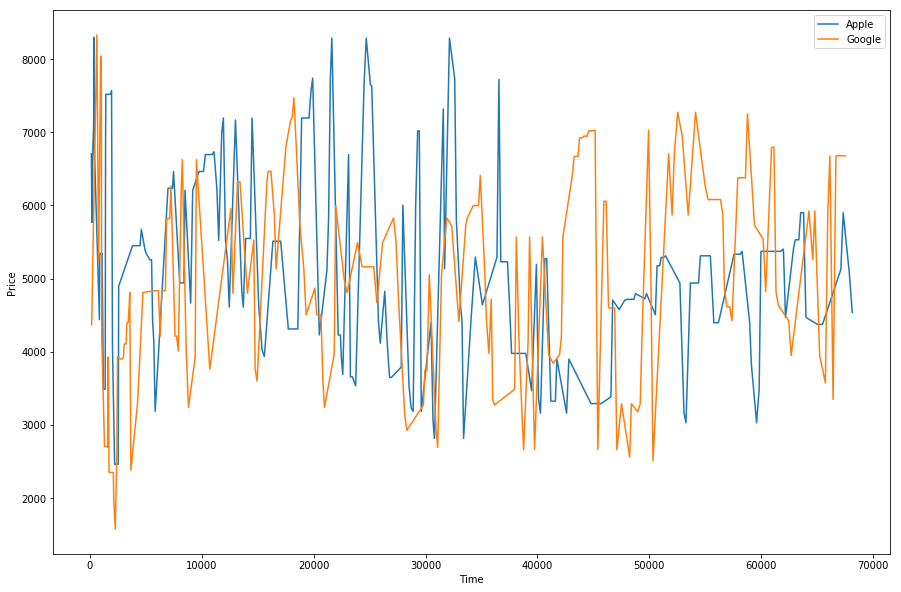

In [9]:
Prices = extract_prices('trace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

### Affichage de l'évolution du wealth des agents

À la fin d'une simulation, on peut accéder au wealth d'un agent avec la méthode `get_wealth` (qui prend le marché en paramètre). Par exemple, on peut afficher les caractéristiques (avec la méthode `get_infos`) de l'agent le plus riche et du plus pauvre:

In [10]:
t_max = m.traders[0]
t_min = m.traders[0]
for t in m.traders: # On parcourt l'ensemble des traders
    if t.get_wealth(m) > t_max.get_wealth(m):
        t_max = t
    elif t.get_wealth(m) < t_max.get_wealth(m):
        t_min = t
print("Agent le plus riche - "+t_max.get_infos(m))
print("Agent le plus pauvre - "+t_min.get_infos(m))

Agent le plus riche - ZIT 11:
Cash: -233495
Apple: 27
Google: 43
Wealth: 176174

Agent le plus pauvre - ZIT 10:
Cash: 16573
Apple: 15
Google: -7
Wealth: 37860



On peut aussi afficher l'évolution du wealth de tous les agents, en lisant la trace : la fonction `extract_wealths` prend un nom de fichier en entrée et retourne un dictionnaire dont les clés sont les agents et les valeurs sont des listes (T, W) où T est la liste des timestamps et W la liste des wealths de cet agent.

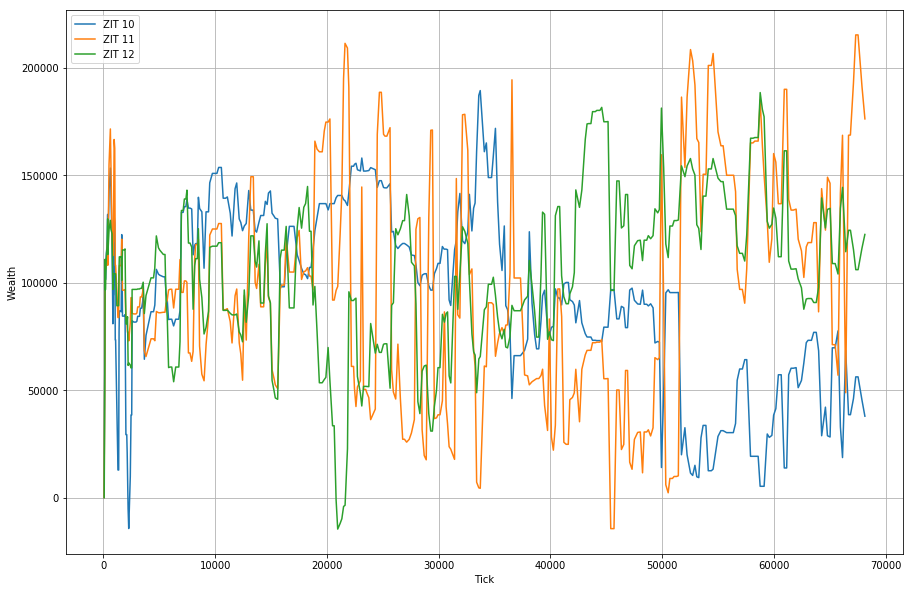

In [11]:
Wealth = extract_wealths('trace.dat')
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

### Affichage des rentabilités

On peut aussi afficher la séquence des rentabilités en utilisant numpy : si $p_n$ est le $n$-ème élément de Prices, alors
> (Prices[1:]-Prices[:-1])/Prices[:-1] (resp. np.log(Prices[1:]) - np.log(Prices[:-1]))

donne la séquence des $\dfrac{p_{n+1}-p_n}{p_n}$ (resp. $\ln(p_{n+1})-\ln(p_n)$).

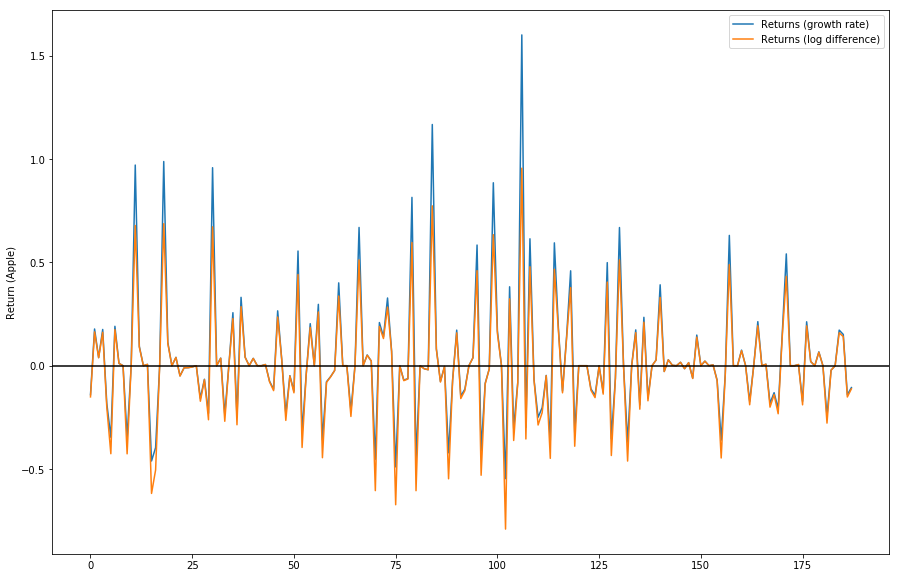

In [12]:
asset = 'Apple'
Prices = np.array(extract_prices('trace.dat')[asset][1])
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

On peut afficher l'histogramme des rentabilités (définies comme la différence logarithmique). Pour cela, on dispose d'une fonction `process_returns_hist`, qui prend en entrées le nom du fichier dans lequel la trace est stockée, le nom de l'asset pour lequel on va calculer les rentabilités, et un nombre de points. En retour, on obtient un tuple (R, D, N) où R est une liste des rentabilités, D la liste de leur densités et N la densité de la loi normale de même espérance et de même écart-type.

In [13]:
# On fait notre generate
# Mieux vaut avoir beaucoup de points, même si c'est un peu long à calculer.
file = open('trace.dat', 'w')
asset = 'Apple'
m = Market([asset], out=file)
m.generate(10, 10000)
file.close()

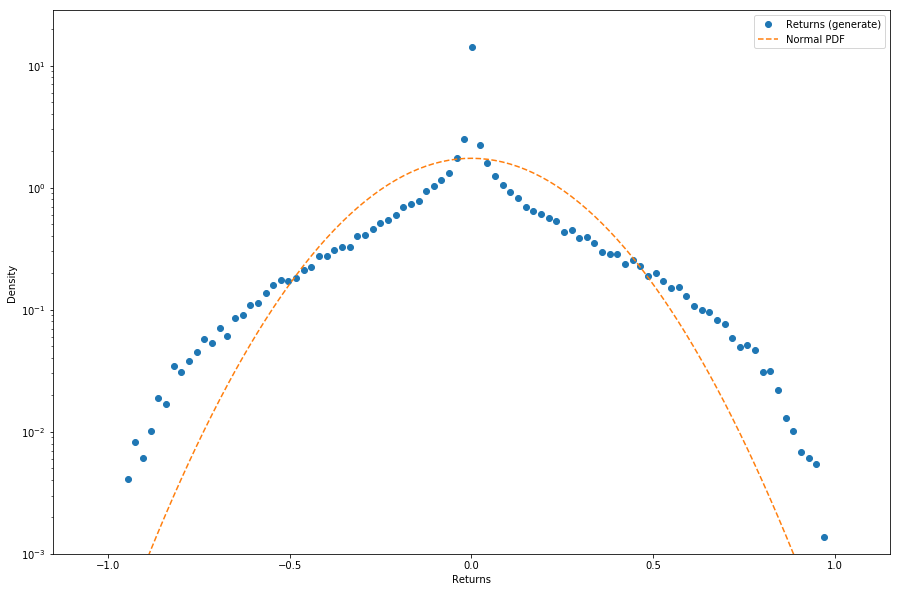

In [14]:
R, D, N = process_returns_hist('trace.dat', asset, 100)
plt.semilogy(R, D, 'o', label='Returns (generate)')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend(loc='best')
r = np.max(np.abs(R))*1.05
plt.axis([-r, r, 10**-3, max(D)*2])
plt.show()

On observe bien le fait stylisé associé à la rentabilité : par rapport à une gaussienne de même espérance et même écart type, on a une forte kurtosis (pic central de plus grande amplitude) et des queues plus épaisses.

Remarque : Pourquoi choisir la différence logarithmique plutôt que le taux d'accroissement ?
Parce que la différence logarithmique a une belle propriété : si on passe d'un prix $p$ à un prix $p'$, alors la rentabilité sera de $r_1 = \log(p') - \log(p)$ ; si on passe de $p'$ à $p$, on a une rentabilité de $r_2 = log(p) - log(p') = -r_1$. Cette propriété n'est pas vérifiée par le taux d'accroissement : si on se limite à des prix tirés entre 1000 et 10000, le taux d'accroissement maximal est 9, et le taux d'accroissement minimal est $-0.9$. La distribution des rentabilités définies comme taux d'accroissement ne sera donc pas symétrique.

Remarque 2 : Cette distinction est importante car on travaille avec ZIT qui font que les prix peuvent subir de fortes variations soudaines. Sur un vrai marché, ces variations sont faibles, et donc si on passe d'un prix $p$ à un prix $p'$, on a $\Delta(p) = |p'-p| << p$, donc : $log(p') - log(p) = \log\left(1+\dfrac{p'-p}{p}\right) \sim \dfrac{p'-p}{p}$. Ainsi, sur un vrai marché, peut importe la définition choisie, on aura grosso modo le même résultat.

### Histogramme des rentabilité quand les prix sont fixés aléatoirement

Le but de cette partie est de montrer que le fait stylisé qu'on obtient avec un marché financier à carnet d'ordres asynchrone ne peut être obtenu avec des prix fixés aléatoirement.
On va générer une fausse trace dans laquelle des prix (500000) sont fixés aléatoirement uniformément entre 1 et 100.

In [15]:
# On créé notre ausse trace dans laquelle les prix sont fixés aléatoirement.
out = open('fake_trace.dat', 'w')
t0 = int(time.time()*1000000)
for i in range(500000):
    out.write("Price;Apple;Agent 0;Agent 0;%i;1;%i\n" % (random.randint(1000, 9999), int(time.time()*1000000)-t0))
out.close()

On va alors afficher l'histogramme des rentabilités.

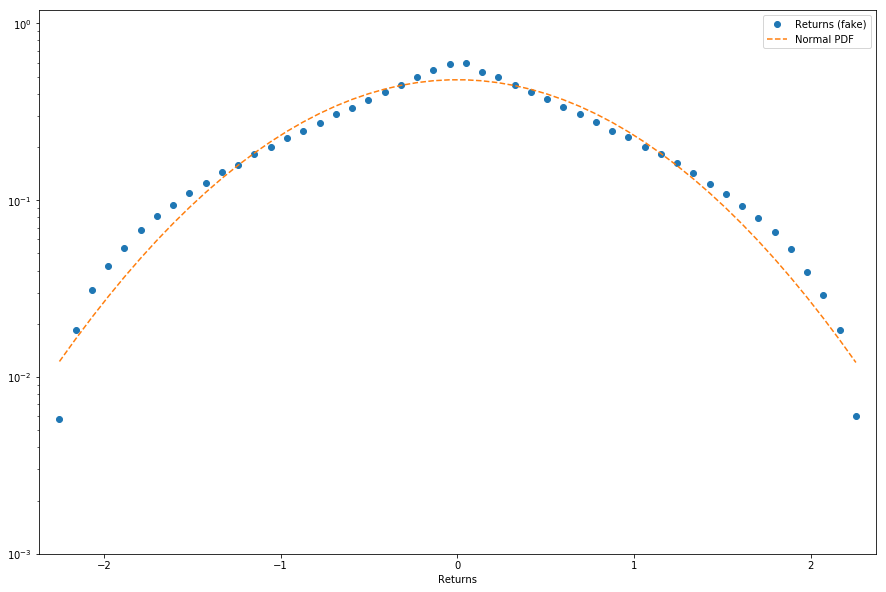

In [16]:
R, D, N = process_returns_hist('fake_trace.dat', 'Apple', 50)
# process_returns_hist prend un fichier, un asset et un nombre de points, et retourne un triplet (R, D, N) avec
# R les rentabilités (définies comme la différence logarithmique), D leur densité
# et N leur densité si la distribution de ces rentabilités suivait une loi normale de même espérance et écart-type.
plt.semilogy(R, D, 'o', label='Returns (fake)')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.legend(loc='best')
r = np.max(np.abs(R))*1.05
plt.axis([-r, r, 10**-3, max(D)*2])
plt.show()

On n'observe plus une sorte de gausienne avec un gros pic et des queues épaisses, mais deux demi-droites.

## Utilisation de replay

On peut passer au marché un fichier d'ordres et d'agents (les lignes "NewAgent" et "*Order" de la trace - seules ces lignes sont lues), et la méthode `replay` du marché va rejouer l'ensemble des opérations effectuées.

In [17]:
m = Market(['LVMH'])
m.replay('orderFileEx1.dat')
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;23;0;LVMH:0
AgentWealth;23;0;4473
LimitOrder;LVMH;23;BID;45500;13
LimitOrder;LVMH;23;BID;42000;14
LimitOrder;LVMH;23;ASK;12000;10
Price;LVMH;23;23;45500;10;4726
Agent;23;0;LVMH;0;4748
AgentWealth;23;0;4776
LimitOrder;LVMH;23;BID;45800;17
LimitOrder;LVMH;23;ASK;11500;10
Price;LVMH;23;23;45800;10;4859
Agent;23;0;LVMH;0;4904
AgentWealth;23;0;4951
LimitOrder;LVMH;23;ASK;36000;12
Price;LVMH;23;23;45800;7;5018
Agent;23;0;LVMH;0;5050
AgentWealth;23;0;5094
Price;LVMH;23;23;45500;3;5172
Agent;23;0;LVMH;0;5215
AgentWealth;23;0;5251
Price;LVMH;23;23;42000;2;5289
Agent;23;0;LVMH;0;5320
AgentWealth;23;0;5351
LimitOrder;LVMH;23;ASK;38500;12
Price;LVMH;23;23;42000;12;5423
Agent;23;0;LVMH;0;5454
AgentWealth;23;0;5484
Limi

### Cercle vertueux

On va générer une trace avec `generate`, puis faire un `replay` sur cette trace. On devrait observer que l'état final du système est identique dans les deux cas. Pour être sûr que `replay` ne triche pas, on va uniquement afficher les ligne NewAgent et LimitOrder dans la trace.

In [4]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file, trace={i: False for i in ['tick', 'price', 'agent', 'wealth', 'orderbook']})
m.generate(2, 1000, init_assets=10, init_cash=100000)
file.close()

for t in m.traders:
    print(t.get_infos(m))

ZIT 5:
Cash: 2920305
Apple: -101
Google: -48
Microsoft: -312
Wealth: -61628

ZIT 6:
Cash: -2720305
Apple: 121
Google: 68
Microsoft: 332
Wealth: 634088



In [5]:
m2 = Market(['Apple', 'Google', 'Microsoft'], out=None)
m2.replay('trace.dat')

for t in m2.traders:
    print(t.get_infos(m2))

7:
Cash: 2920305
Apple: -101
Google: -48
Microsoft: -312
Wealth: -61628

8:
Cash: -2720305
Apple: 121
Google: 68
Microsoft: 332
Wealth: 634088



C'est bien ce qu'on observe ! (Nos agents ont juste des noms différents.)